In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing


%config InlineBackend.figure_format = 'retina'


from sklearn import linear_model
from sklearn import metrics

# Part A

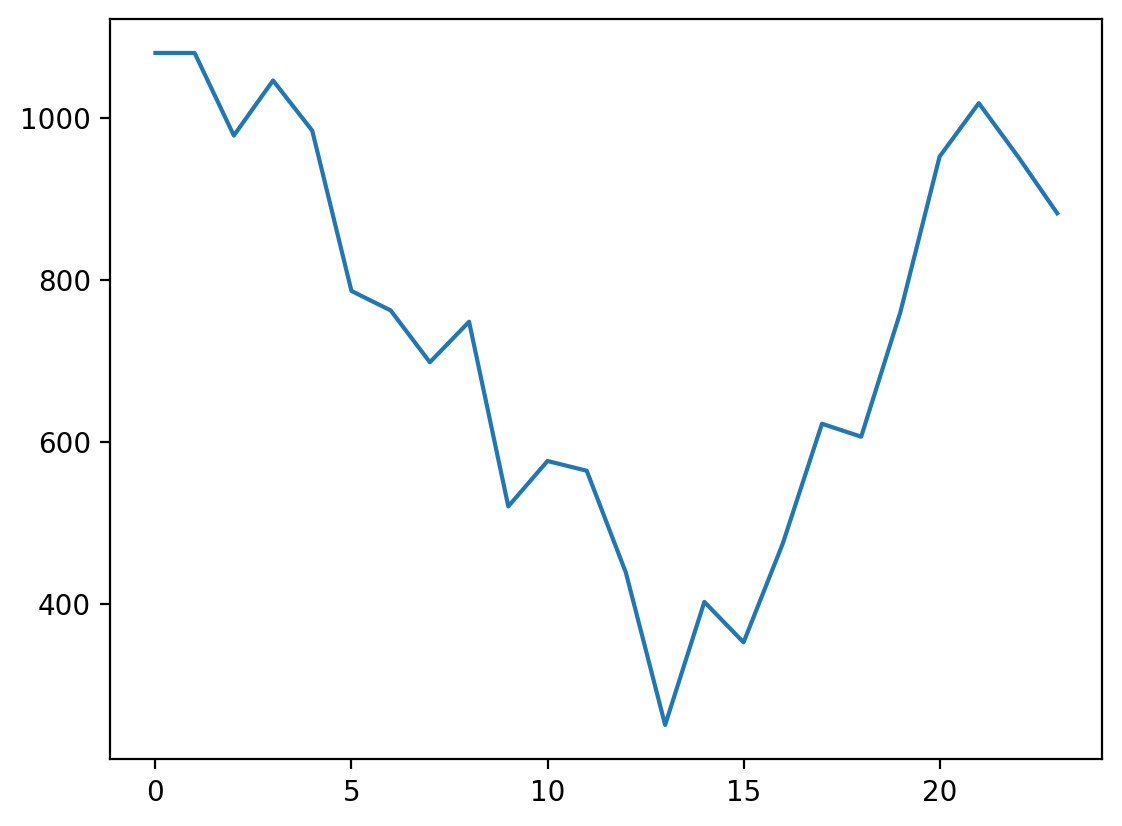

,0,1,2,3,4
0,0.681535,0.157763,0.460930,0.523772,0.154359
1,0.629598,-0.060354,0.293995,0.689952,0.193642
2,0.711922,0.099628,0.290537,0.612294,0.154681
3,0.701712,0.048853,0.224429,0.652858,0.169179
4,0.709333,0.082586,0.255677,0.626747,0.178451
...,...,...,...,...,...
360,0.562063,-0.152283,0.321756,0.714346,0.216977
361,0.680424,0.036681,0.299787,0.643744,0.177197
362,0.498562,-0.285940,0.159039,0.784502,0.170111
363,0.517214,-0.238916,0.208177,0.756131,0.245636


In [335]:
data = np.array(pd.read_csv("./rsfmeasureddata2011.csv")["Building Net (kW)"])


# Split year into 365 day instances or "customers"
all_days = np.array_split(data, 365)
all_days[0][0] = all_days[0][1]


plt.plot(all_days[0])
plt.show()


# Functions to calculate attributes. These are just some examples we could change these.
def max_w(day):
    return np.max(day)


def min_w(day):
    return np.min(day)


def avg_w(day):
    return np.average(day)


def diff_w(day):
    return np.max(day) - np.min(day)


def std(day):
    return np.std(day)


def energy(day):
    return np.trapz(day)


# attribute_array = []
attribute_array = np.empty((0, 5))
for i in range(len(all_days)):
    attribute_array = np.append(
        attribute_array,
        [
            [
                max_w(all_days[i]),
                min_w(all_days[i]),
                avg_w(all_days[i]),
                diff_w(all_days[i]),
                std(all_days[i]),
            ]
        ],
        axis=0,
    )

# for day in all_days:
#     attribute_array = [
#         *attribute_array,
#         [
#             max_w(day),
#             min_w(day),
#             avg_w(day),
#             diff_w(day),
#             std(day),
#             # energy(day),
#         ],
#     ]

attribute_array = preprocessing.normalize(attribute_array) # [preprocessing.normalize(aa) for aa in attribute_array]
pd.DataFrame(attribute_array)

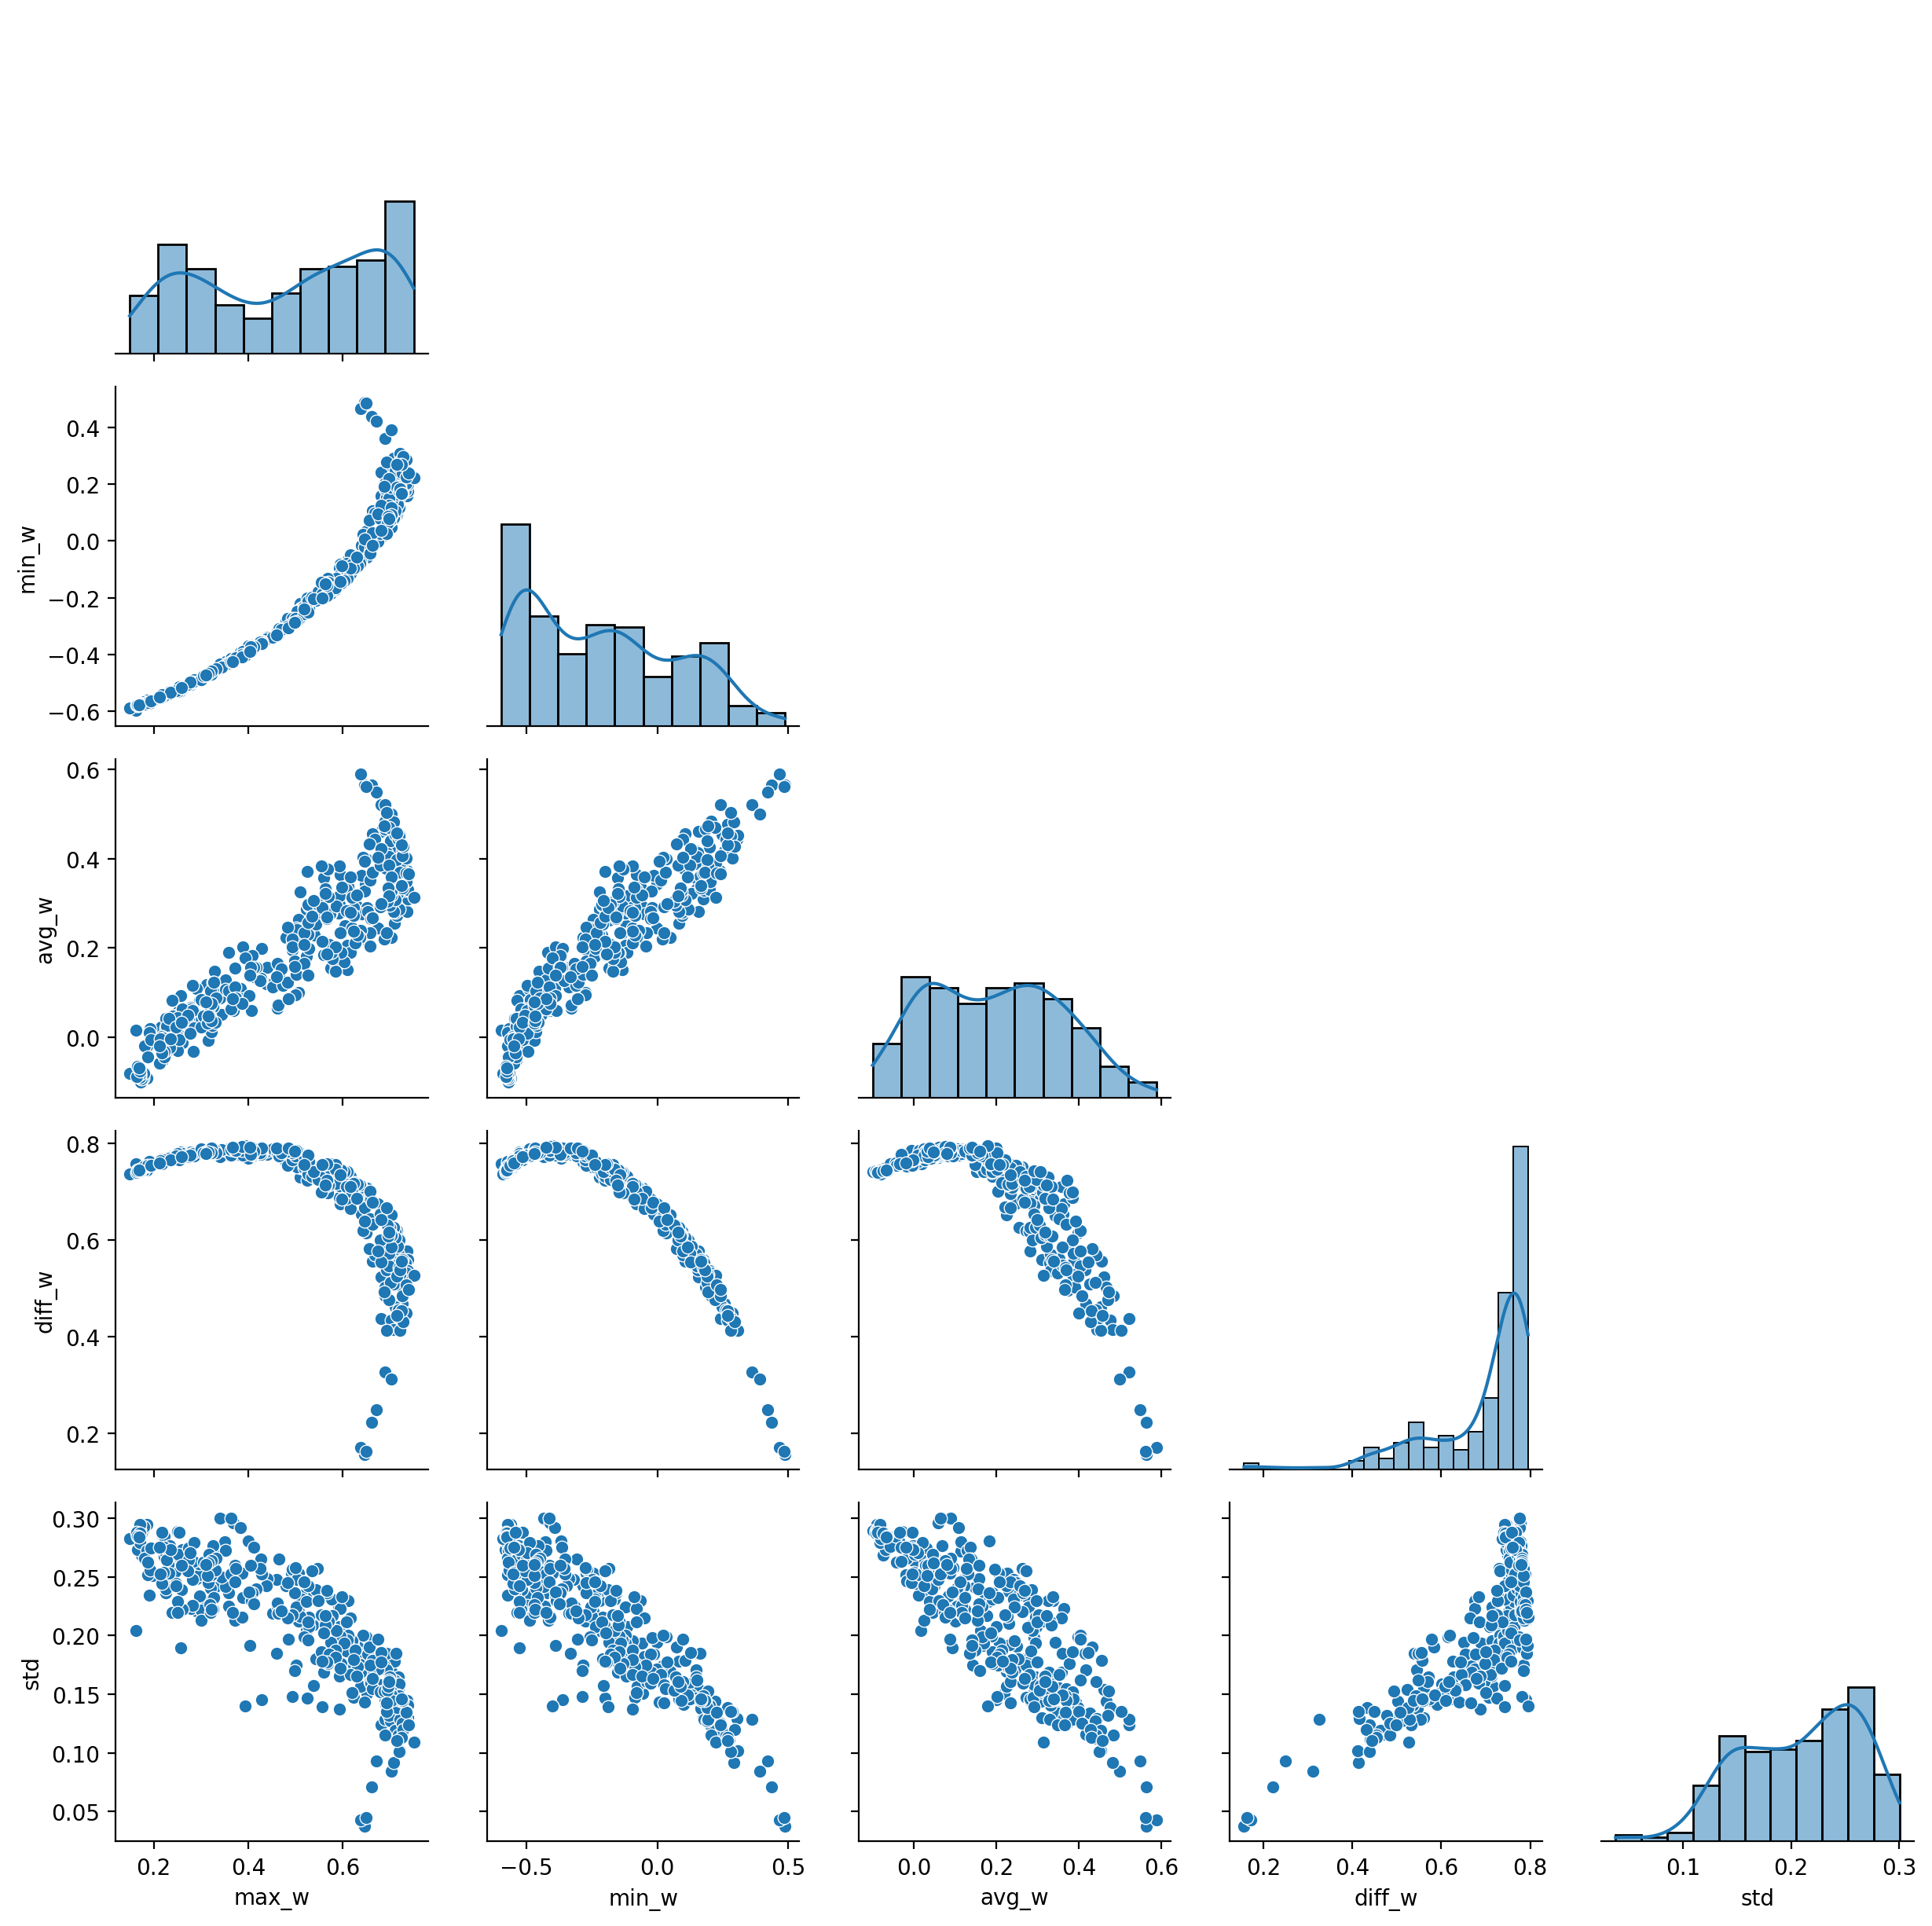

In [336]:
import seaborn as sns

df = pd.DataFrame(
    attribute_array,
    columns=[
        "max_w",
        "min_w",
        "avg_w",
        "diff_w",
        "std",
        # "energy",
    ],
)
df.to_csv("PartA.csv")
g = sns.PairGrid(df, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, kde=True)

# Part B

2 0.5909834813782795
3 0.590734461475973
4 0.5325687814032962
5 0.4826976855505199
6 0.44933245574728675
7 0.43931956754922996
8 0.4118589720771428
9 0.40412688247163814
10 0.3724638202496255
11 0.379426252265395


InvalidParameterError: The 'metric' parameter of pairwise_distances must be a str among {'manhattan', 'sokalmichener', 'russellrao', 'precomputed', 'l2', 'jaccard', 'sokalsneath', 'cosine', 'haversine', 'matching', 'euclidean', 'canberra', 'wminkowski', 'nan_euclidean', 'sqeuclidean', 'correlation', 'mahalanobis', 'seuclidean', 'chebyshev', 'minkowski', 'dice', 'l1', 'rogerstanimoto', 'yule', 'hamming', 'braycurtis', 'cityblock'} or a callable. Got array([[ 0.        ,         nan,  3.49851253, ...,         nan,
         6.43112252,         nan],
       [        nan,  0.        ,  2.06489703, ...,  3.1277844 ,
         2.46270292,  6.82769922],
       [ 3.49851253,  2.06489703,  0.        , ...,  6.58454799,
         1.79012248, 10.42881194],
       ...,
       [        nan,  3.1277844 ,  6.58454799, ...,  0.        ,
         3.61959101,  2.61926967],
       [ 6.43112252,  2.46270292,  1.79012248, ...,  3.61959101,
         0.        ,  1.32128269],
       [        nan,  6.82769922, 10.42881194, ...,  2.61926967,
         1.32128269,  0.        ]]) instead.

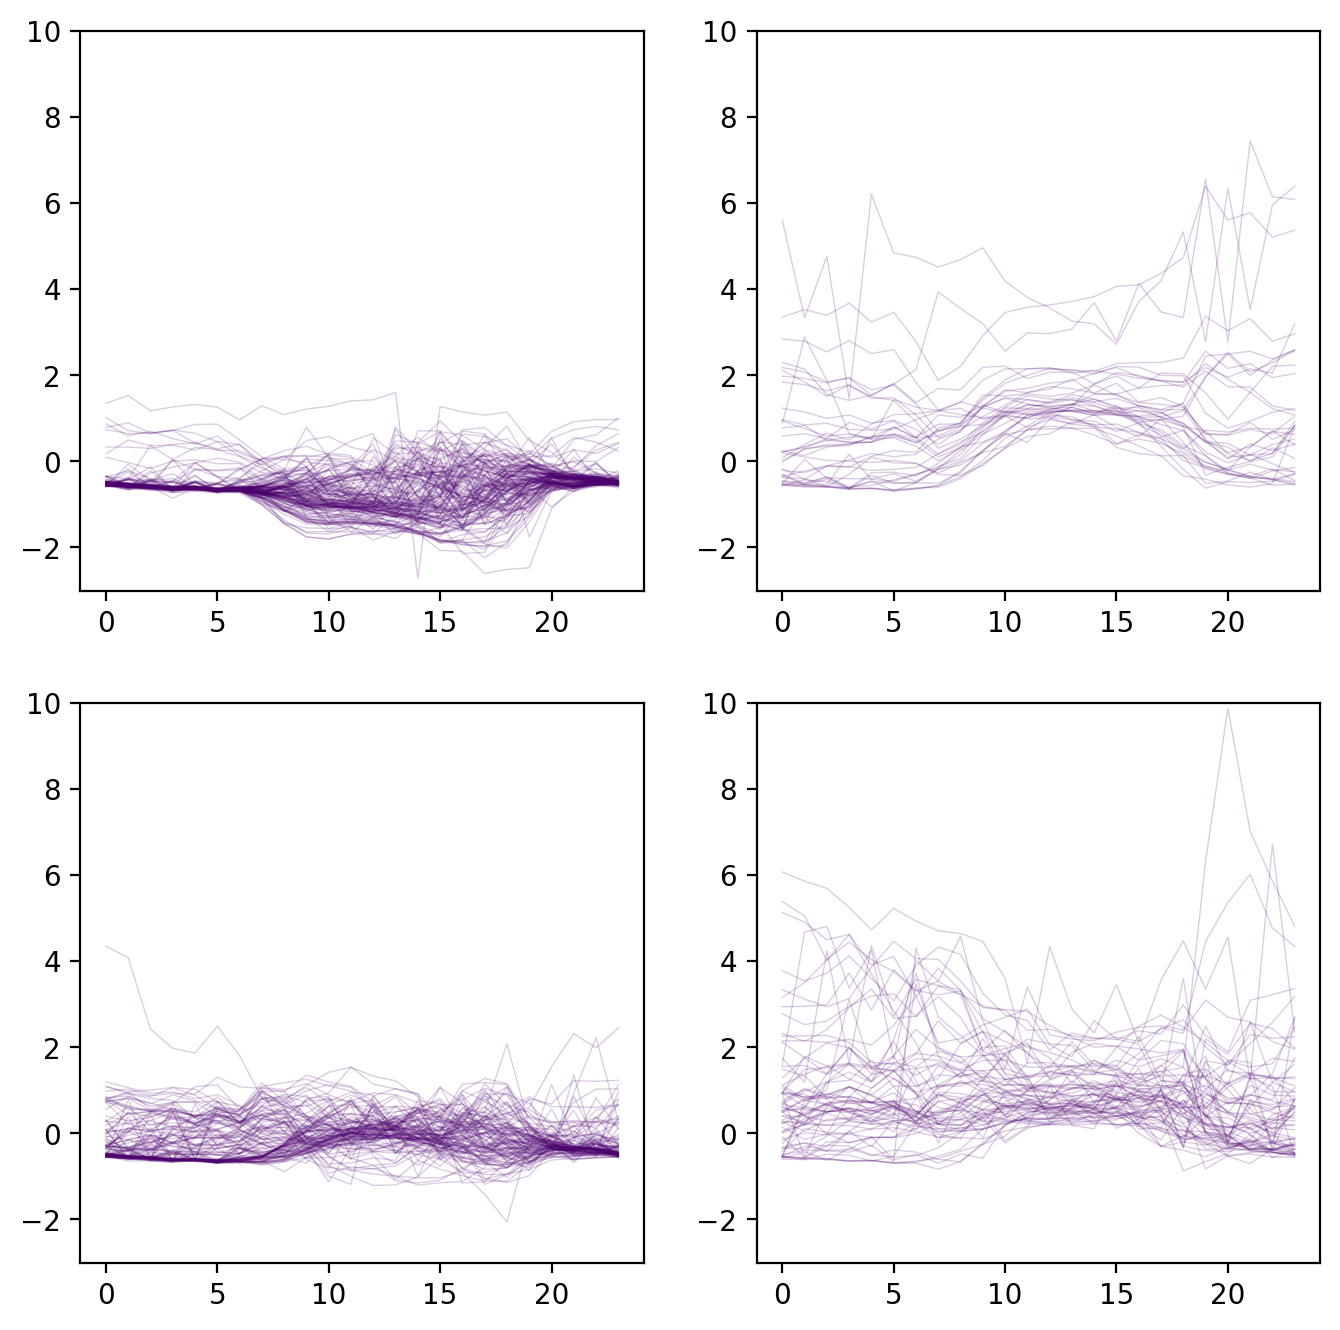

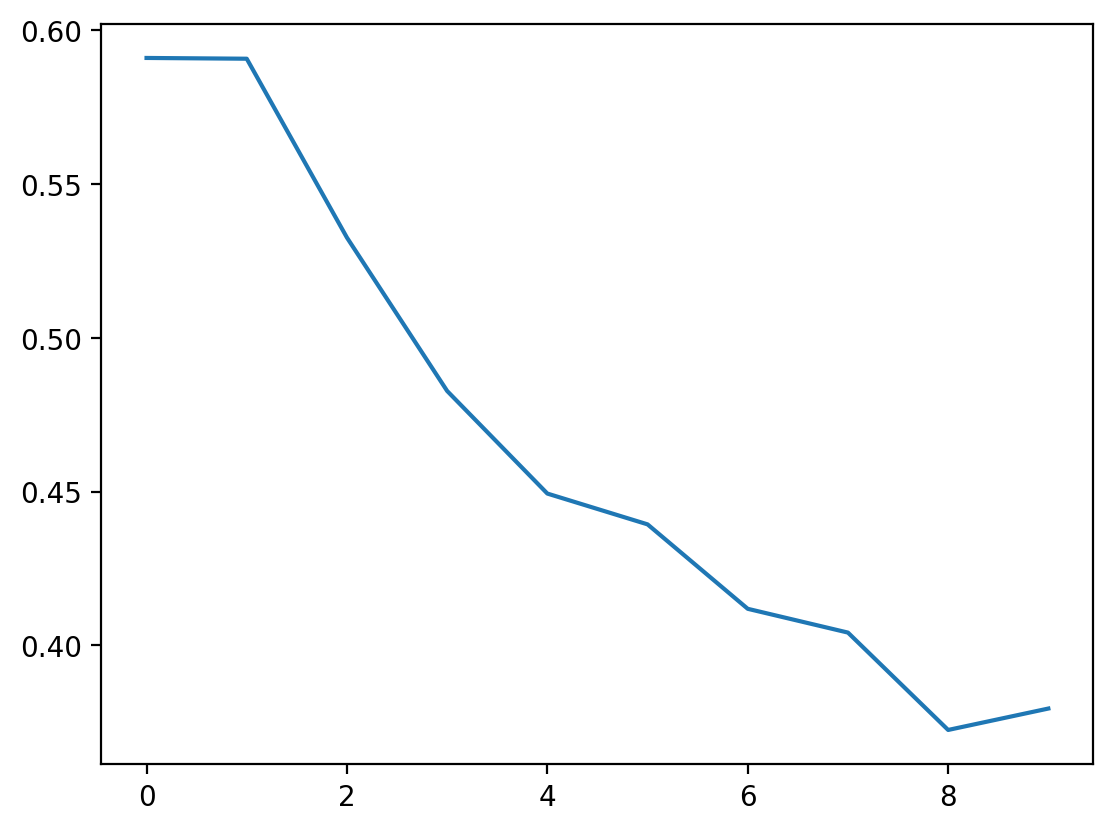

In [343]:
n_clusters_arr = np.arange(2, 12)

scores = []
for n_clusters in n_clusters_arr:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    cluster_array = kmeans.fit_predict(attribute_array)
    # print(cluster_array)
    # I'm not sure how to best visualize this
    # How about like this

    if n_clusters == 4:
        fig, axs = plt.subplots(int(math.ceil(n_clusters / 2)), 2, figsize=(8, 8))
        axs = axs.flatten()

        np_scaled = StandardScaler().fit_transform(all_days)

        for idx, cluster_label in enumerate(cluster_array):
            np_profs = np_scaled[idx, :].T
            axs[cluster_label].plot()
            axs[cluster_label].plot(
                np_profs, alpha=0.2, linewidth=0.5, color="xkcd:royal purple"
            )

        for cluster_idx in set(cluster_array):
            axs[cluster_idx].set_ylim(-3, 10)

    score = metrics.silhouette_score(attribute_array, cluster_array, metric="euclidean")
    print(n_clusters, score)
    scores = [*scores, score]

plt.figure()
plt.plot(scores)


from sklearn_extra.cluster import KMedoids


scores = []
for n_clusters in n_clusters_arr:
    kmeans = KMedoids(
        n_clusters=n_clusters,
        random_state=0,
        metric=metrics.pairwise_distances(attribute_array, metric="mahalanobis"),
        # metric_params={"VI": np.cov(attribute_array, rowvar=False)},
    )
    cluster_array = kmeans.fit_predict(attribute_array)
    # print(cluster_array)
    # I'm not sure how to best visualize this
    # How about like this

    if n_clusters == 4:
        fig, axs = plt.subplots(int(math.ceil(n_clusters / 2)), 2, figsize=(8, 8))
        axs = axs.flatten()

        np_scaled = StandardScaler().fit_transform(all_days)

        for idx, cluster_label in enumerate(cluster_array):
            np_profs = np_scaled[idx, :].T
            axs[cluster_label].plot()
            axs[cluster_label].plot(
                np_profs, alpha=0.2, linewidth=0.5, color="xkcd:royal purple"
            )

        for cluster_idx in set(cluster_array):
            axs[cluster_idx].set_ylim(-3, 10)

    score = metrics.silhouette_score(attribute_array, cluster_array, metric="euclidean")
    print(n_clusters, score)
    scores = [*scores, score]

plt.figure()
plt.plot(scores)

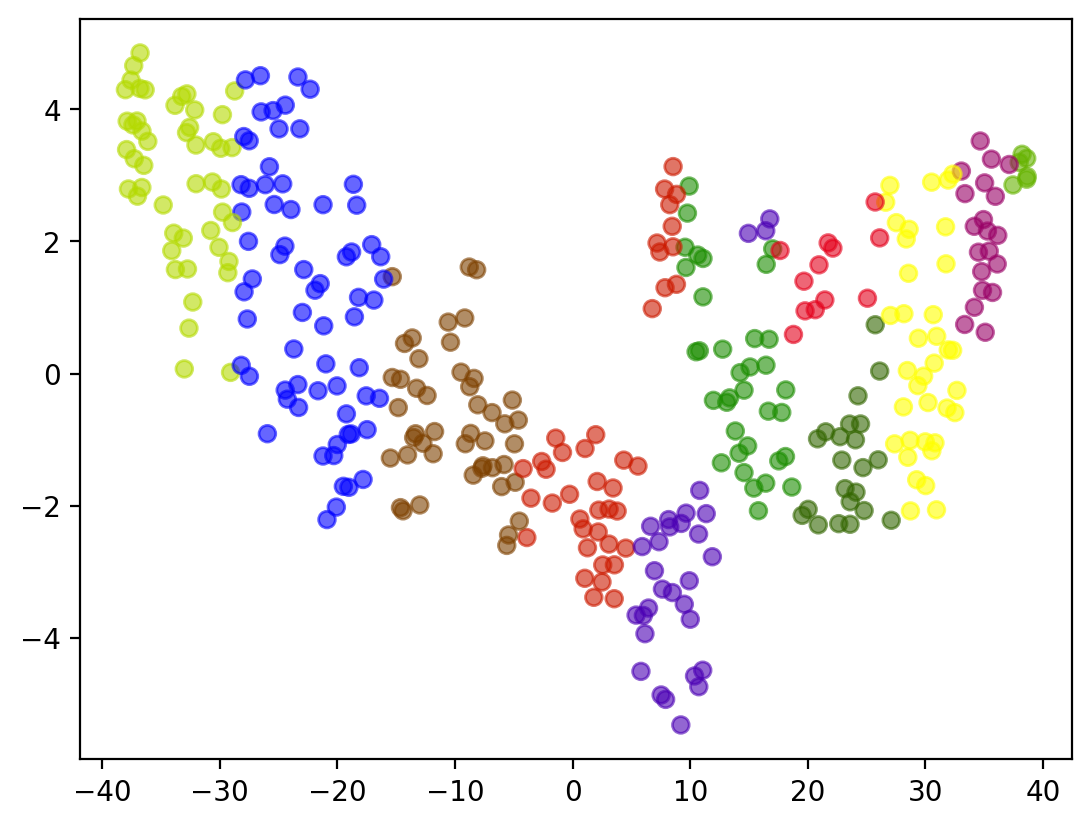

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.colors

tsne = TSNE()
results_tsne = tsne.fit_transform(attribute_array)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    cluster_array, ["blue", "red", "green", "yellow"]
)

# color_arr =

plt.scatter(
    results_tsne[:, 0],
    results_tsne[:, 1],
    c=cluster_array,
    cmap=cmap,
    alpha=0.6,
)

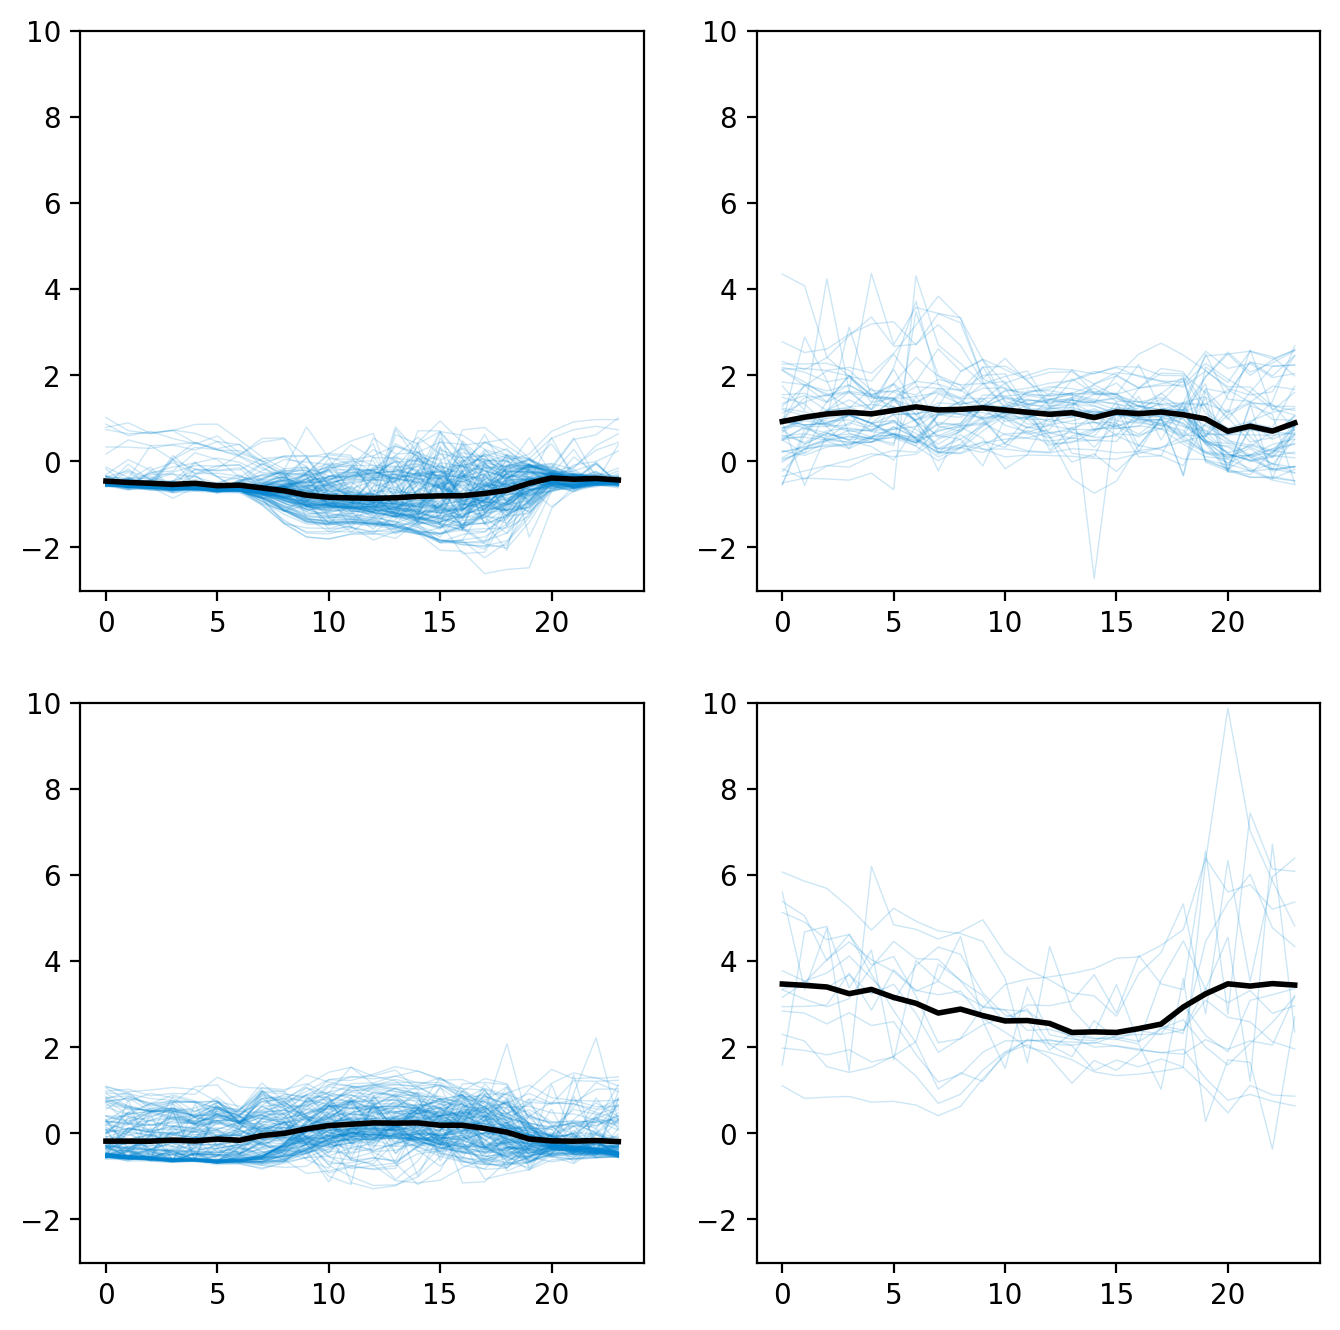

In [ ]:
# This isn't actually what we've been asked to do but it might give us a better idea of number of clusters. Uses the whole time series of each day as opposed to the attributes


np_scaled = StandardScaler().fit_transform(all_days)


n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=100, n_init="auto")

df_preds = kmeans.fit_predict(np_scaled)

fig, ax = plt.subplots(int(math.ceil(n_clusters / 2)), 2, figsize=(8, 8))
ax = ax.flatten()

avgs = []
cluster_pop = []
for idx in np.unique(df_preds):
    indices = np.where(df_preds == idx)[0]

    cluster_pop.append(len(indices))
    np_profs = np_scaled[indices, :].T

    ax[idx].plot(np_profs, alpha=0.2, linewidth=0.5, color="xkcd:cerulean")

    ax[idx].plot(np.mean(np_profs, axis=1), color="black", linewidth=2)
    ax[idx].set_ylim(-3, 10)
    avgs.append(np.mean(np_profs, axis=1))

# Part C

Logistic Regression Classifier
	prediction [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 3 2 2 3 3 3 3 2 2 2 2 2 0]
	actual     [1 3 1 1 1 3 1 1 1 3 3 1 3 3 3 3 2 2 1 2 3 1 3 3 3 3 2 3 2 2 0]
	score on train 0.8772455089820359
	score on test 0.5483870967741935
	0.5483870967741935

K Neighbors Classifer
	prediction [1 3 1 1 1 3 1 1 1 3 3 1 3 3 3 3 2 2 1 2 3 1 3 3 3 3 2 3 2 2 0]
	actual     [1 3 1 1 1 3 1 1 1 3 3 1 3 3 3 3 2 2 1 2 3 1 3 3 3 3 2 3 2 2 0]
	score on train 0.9850299401197605
	score on test 1.0

Linear Discriminant Analysis
	prediction [1 3 1 1 1 3 1 1 3 3 3 3 3 3 3 3 2 2 1 2 3 1 3 3 3 3 2 3 2 2 0]
	actual     [1 3 1 1 1 3 1 1 1 3 3 1 3 3 3 3 2 2 1 2 3 1 3 3 3 3 2 3 2 2 0]
	score on train 0.9610778443113772
	score on test 0.9354838709677419


Text(0.5, 1.0, 'LDA')

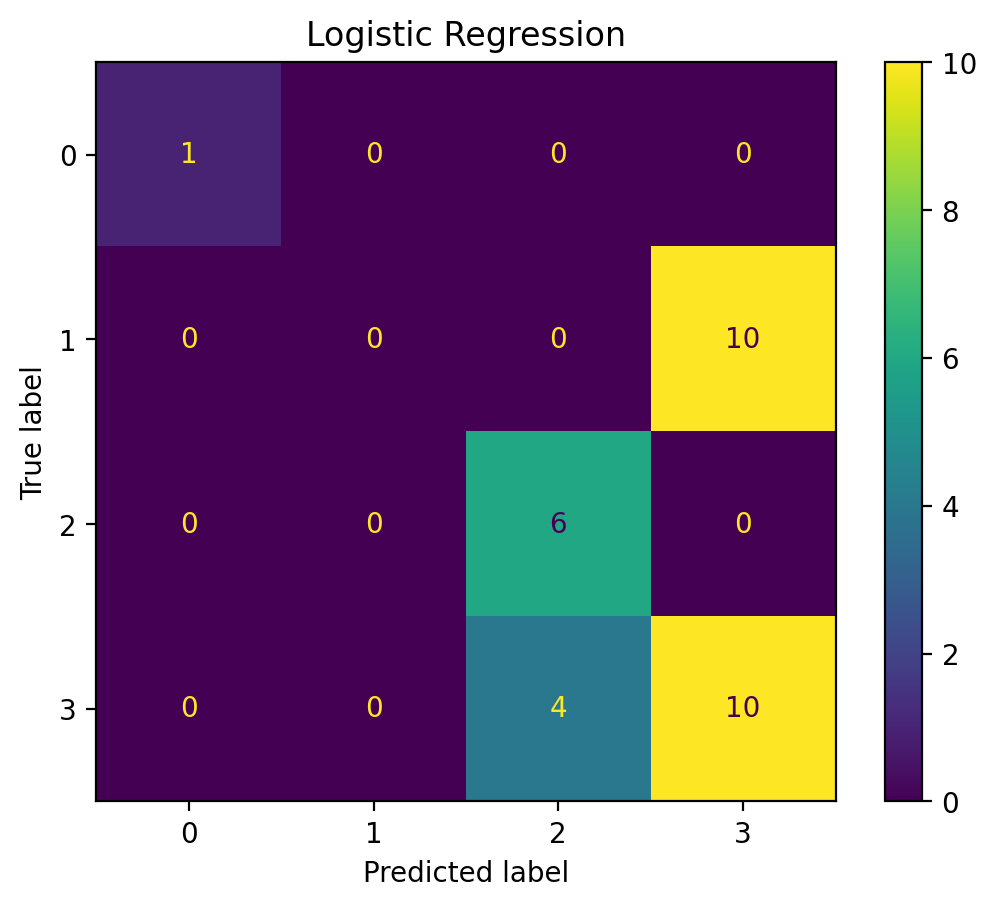

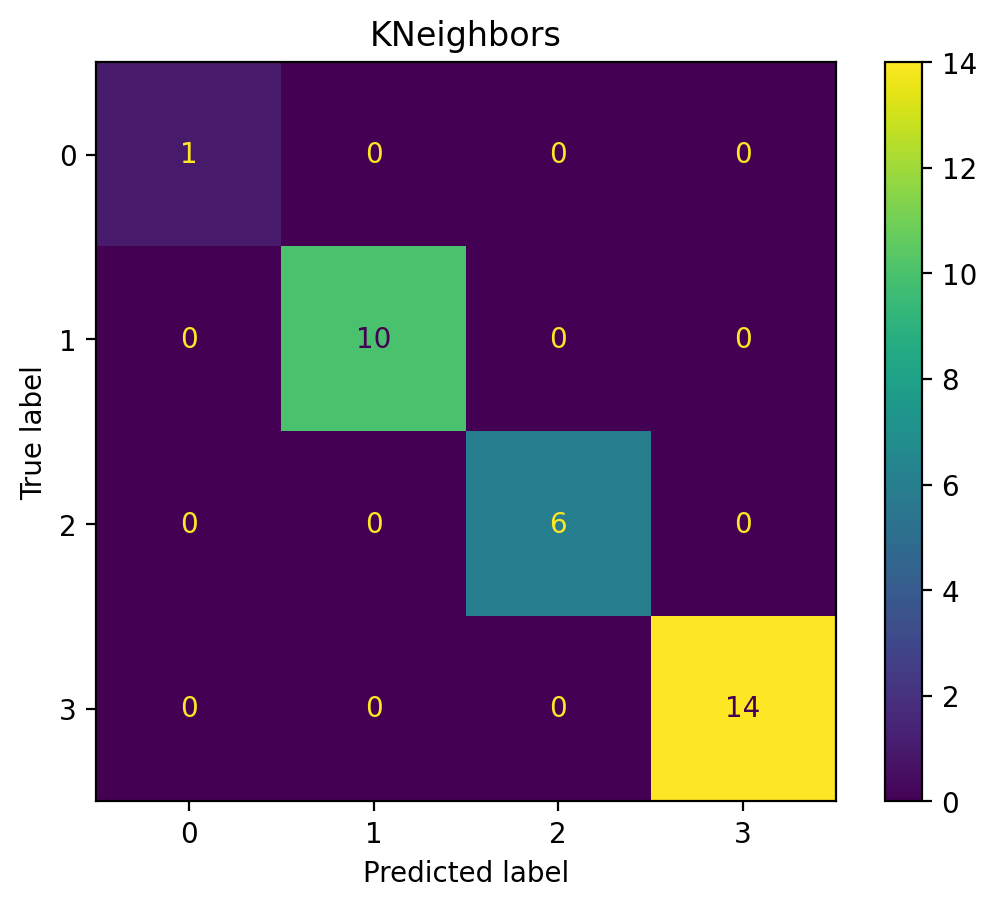

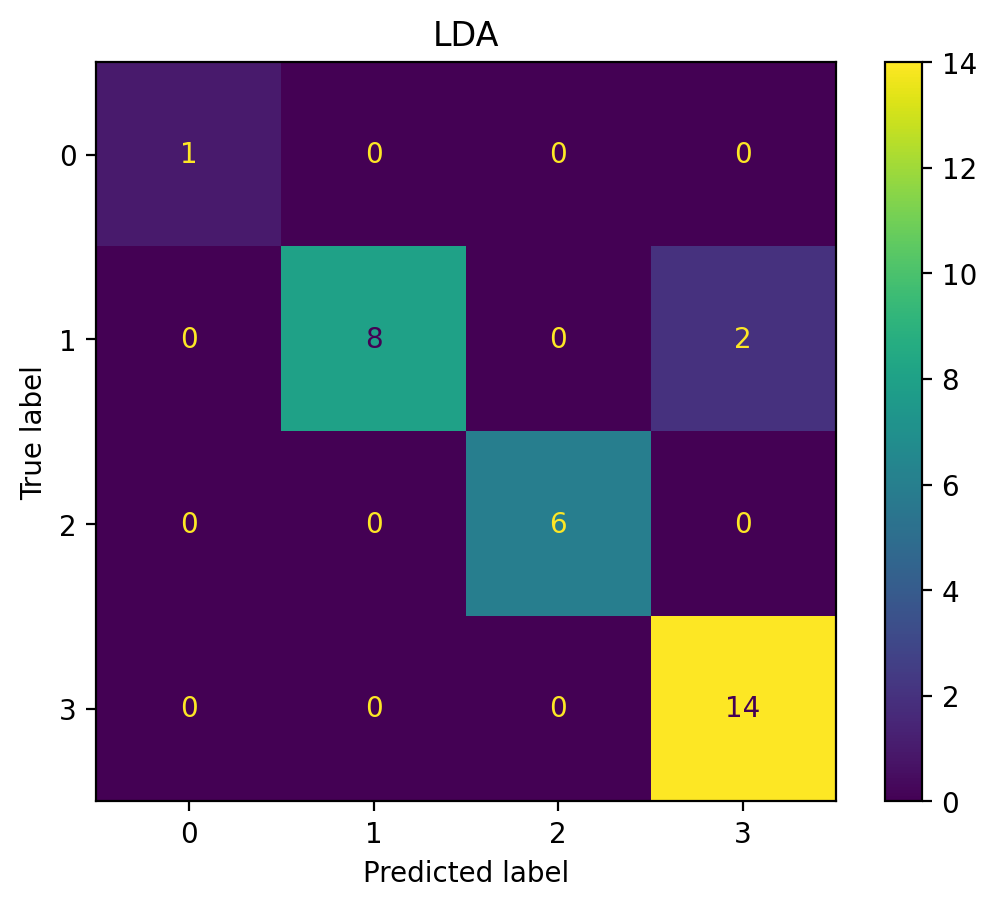

In [ ]:
x_train = attribute_array[:334][:]
x_test = attribute_array[-31:][:]
y_train = cluster_array[:334]
y_test = cluster_array[-31:]


# Logistic regression classifier
print("Logistic Regression Classifier")
lr = linear_model.LogisticRegression()
lr.fit(x_train, y_train)


prediction = lr.predict(x_test)
print("\tprediction", prediction)
print("\tactual    ", y_test)
print("\tscore on train", lr.score(x_train, y_train))
print("\tscore on test", lr.score(x_test, y_test))
print(f"\t{metrics.accuracy_score(y_test, prediction)}")  # same resullt as above line

confusion = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion)
disp.plot()
ax = plt.gca()
ax.set_title("Logistic Regression")


# KNeighbors Classifier
print("\nK Neighbors Classifer")
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train, y_train)
prediction = neigh.predict(x_test)
print("\tprediction", prediction)
print("\tactual    ", y_test)
print("\tscore on train", neigh.score(x_train, y_train))
print("\tscore on test", neigh.score(x_test, y_test))

confusion = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion)
disp.plot()
ax = plt.gca()
ax.set_title("KNeighbors")


print("\nLinear Discriminant Analysis")

lda_classifier = LinearDiscriminantAnalysis().fit(x_train, y_train)
lda_classifier.fit(x_train, y_train)
prediction = lda_classifier.predict(x_test)
print("\tprediction", prediction)
print("\tactual    ", y_test)
print("\tscore on train", lda_classifier.score(x_train, y_train))
print("\tscore on test", lda_classifier.score(x_test, y_test))

confusion = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion)
disp.plot()
ax = plt.gca()
ax.set_title("LDA")